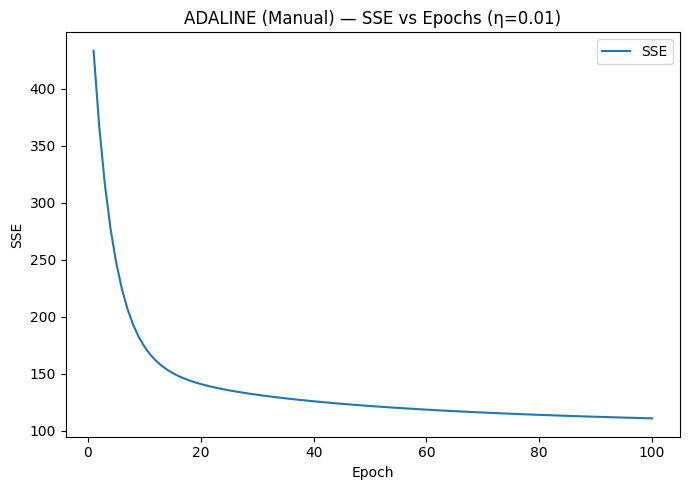


ADALINE Manual (η=0.01) — Test Metrics
Accuracy:0.9580
Precision:0.9468 Recall:0.9889 F1:0.9674
Confusion Matrix (rows=[+1,-1], cols=[+1,-1]):
[[89  1]
 [ 5 48]]


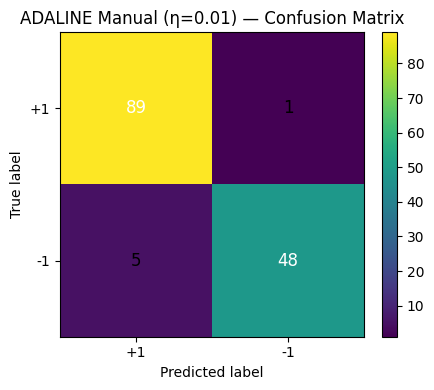

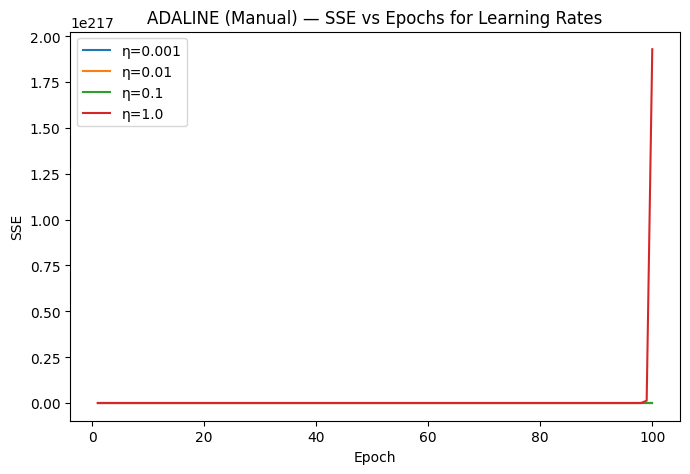

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support

from sklearn.linear_model import SGDRegressor

import torch
import torch.nn as nn

# Reproducibility
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Data Prep
data=load_breast_cancer()
X=data.data.astype(np.float64)
y=data.target.astype(np.int64)

# Map {0,1} -> {-1,+1} for ADALINE
y=np.where(y==0,-1,1)

X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.25,random_state=RANDOM_STATE,stratify=y
)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Helpers
def metrics_report(y_true,y_pred,pos_label=1,name="Model"):
    from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support
    import numpy as np
    import matplotlib.pyplot as plt

    acc=accuracy_score(y_true,y_pred)
    cm=confusion_matrix(y_true,y_pred,labels=[1,-1])
    prec,rec,f1,_=precision_recall_fscore_support(
        y_true,y_pred,average="binary",pos_label=pos_label,zero_division=0
    )

    print(f"\n{name} — Test Metrics")
    print(f"Accuracy:{acc:.4f}")
    print(f"Precision:{prec:.4f} Recall:{rec:.4f} F1:{f1:.4f}")
    print("Confusion Matrix (rows=[+1,-1], cols=[+1,-1]):")
    print(cm)

    fig,ax=plt.subplots(figsize=(5,4))
    im=ax.imshow(cm,interpolation="nearest")
    plt.colorbar(im,ax=ax,fraction=0.046,pad=0.04)

    class_names=["+1","-1"]
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel="Predicted label",
        ylabel="True label",
        title=f"{name} — Confusion Matrix"
    )

    thresh=cm.max()/2.0 if cm.size else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,i,format(cm[i,j],"d"),
                ha="center",va="center",
                color="white" if cm[i,j]>thresh else "black",
                fontsize=12
            )

    plt.tight_layout()
    plt.show()

    return {"accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"cm":cm}


def plot_sse(histories,title):
    plt.figure(figsize=(7,5))
    for label,sse in histories.items():
        plt.plot(range(1,len(sse)+1),sse,label=str(label))
    plt.xlabel("Epoch")
    plt.ylabel("SSE")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# SECTION 1 — MANUAL ADALINE (Delta Rule)
class AdalineManual:
    """
    Batch Gradient Descent ADALINE (identity activation).
    """
    def __init__(self,lr=0.01,epochs=100,random_state=0):
        self.lr=lr
        self.epochs=epochs
        self.random_state=random_state
        self.w_=None
        self.b_=0.0
        self.sse_history_=[]

    def fit(self,X,y):
        rng=np.random.default_rng(self.random_state)
        n_features=X.shape[1]
        self.w_=rng.normal(loc=0.0,scale=0.01,size=n_features)
        self.b_=0.0
        self.sse_history_.clear()

        for _ in range(self.epochs):
            net=X@self.w_+self.b_
            out=net  # identity
            errors=y-out
            self.w_+=self.lr*(X.T@errors)/X.shape[0]
            self.b_+=self.lr*errors.mean()
            sse=float(np.sum(errors**2))
            if not np.isfinite(sse):
                sse=np.inf
            self.sse_history_.append(sse)
        return self

    def predict(self,X):
        return np.where(X@self.w_+self.b_>=0.0,1,-1)

# CLO-1: Train + SSE vs Epochs (Manual)
manual_lr=0.01
manual_epochs=100
adaline_manual=AdalineManual(lr=manual_lr,epochs=manual_epochs,random_state=RANDOM_STATE)
adaline_manual.fit(X_train,y_train)

plot_sse({"SSE":adaline_manual.sse_history_},
         f"ADALINE (Manual) — SSE vs Epochs (η={manual_lr})")

#  Metrics on Test
y_pred_manual=adaline_manual.predict(X_test)
manual_metrics=metrics_report(y_test,y_pred_manual,name=f"ADALINE Manual (η={manual_lr})")

# Learning Rate Experiments
lrs=[0.001,0.01,0.1,1.0]
hist_manual={}
for lr in lrs:
    m=AdalineManual(lr=lr,epochs=manual_epochs,random_state=RANDOM_STATE).fit(X_train,y_train)
    hist_manual[f"η={lr}"]=m.sse_history_

plot_sse(hist_manual,"ADALINE (Manual) — SSE vs Epochs for Learning Rates")

